# Support Vector Machines

## The Data
For this series of lectures, I will be using the famous [Iris flower data set](http://en.wikipedia.org/wiki/Iris_flower_data_set). 

The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by Sir Ronald Fisher in the 1936 as an example of discriminant analysis. 

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor), so 150 total samples. Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

I will focus this project on the SVC model and `gridsearch` for model optimisation and selection. However, I will touch on the full EDA pipeline for good practice, although more superfitially than in other projects due to the simplicity of the data.

## Set up

Import libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

Get the data

In [3]:
iris = sns.load_dataset('iris')

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Exploratory Data Analysis

First, lets get an overview of the relationships in the data by segregating a pairplot across species.

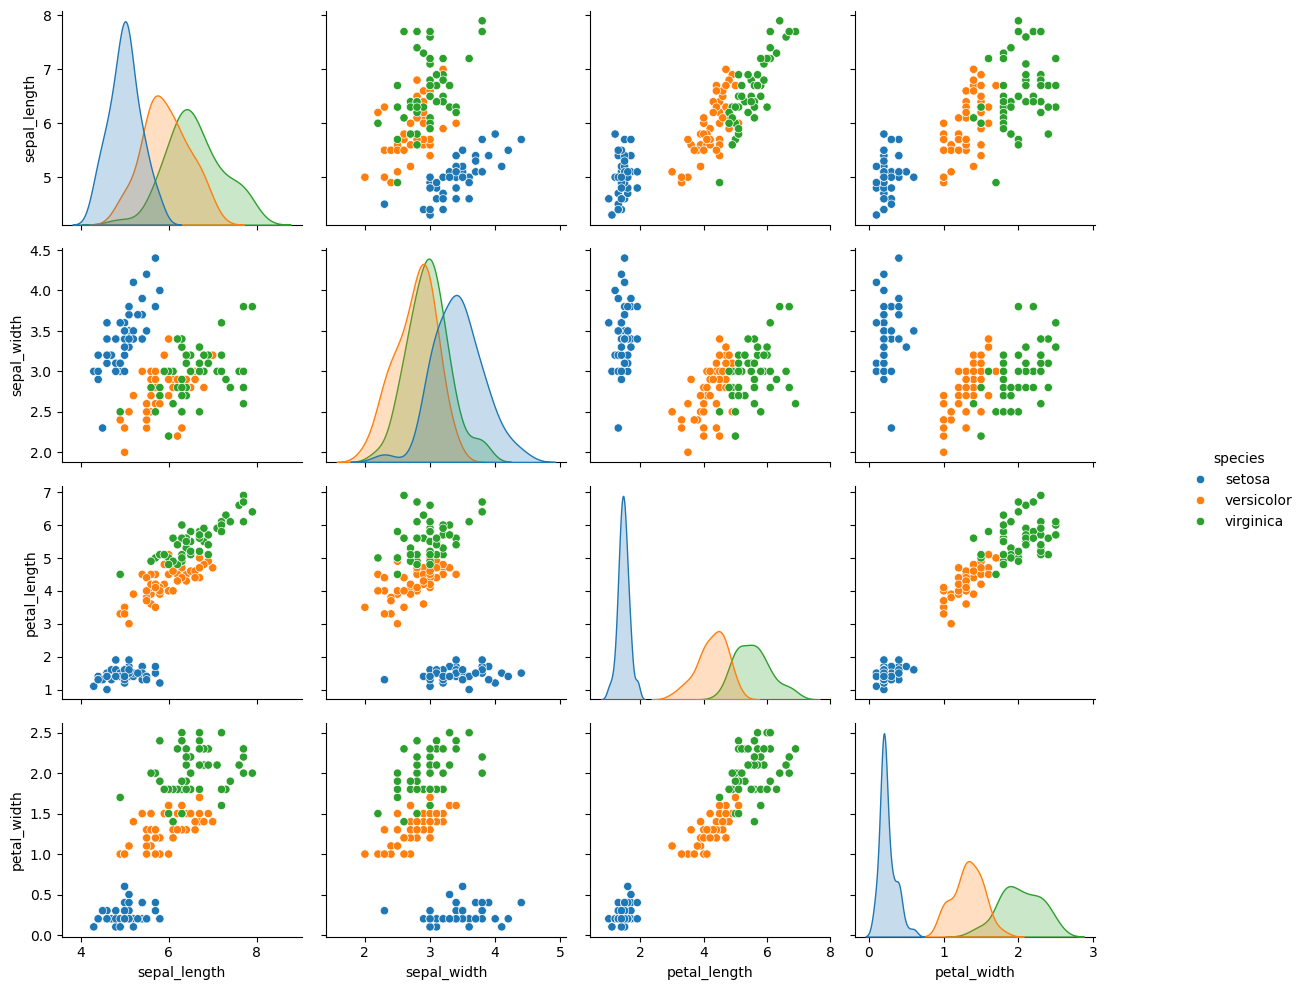

In [6]:
g = sns.pairplot(iris, hue='species')
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_loc('center left')
plt.tight_layout()

We can see a clear separation among species. Setosa is more obviously separated based on any feature, while versicolor and virginica have some clear separation while still slightly overlapping. Thus, setosa is clearly separable, while virginica and versicolor show some overlap that could lead to misclassifications.

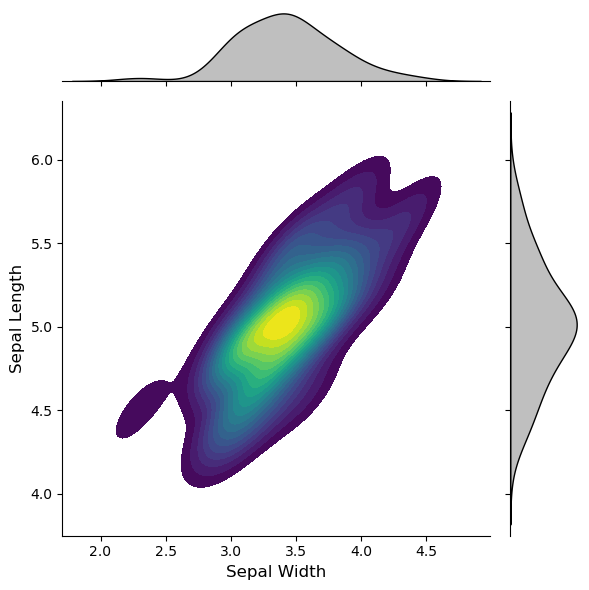

In [7]:
setosa = iris[iris['species'] == 'setosa']

sns.jointplot(x = 'sepal_width', 
            y = 'sepal_length', 
            data = setosa, 
            cmap = 'viridis', 
            fill = True, 
            levels = 20,
           kind = 'kde',
             marginal_kws={"fill": True, 'color' : 'black'})
plt.ylabel('Sepal Length', fontsize=12)
plt.xlabel('Sepal Width', fontsize=12)
plt.tight_layout()

For setosa, there’s a concentration of observations around sepal_length ≈ 5 and sepal_width ≈ 3–350, and overall a slight tendency for sepal length to increase as sepal width increases — though it’s not a strong linear trend. There is also a possible outlier at SW ~ 2.25 and SL ~ 4.5.

## Support Vector Machine Classifier

### Standard data pre-processing

#### Explore correlation among variables

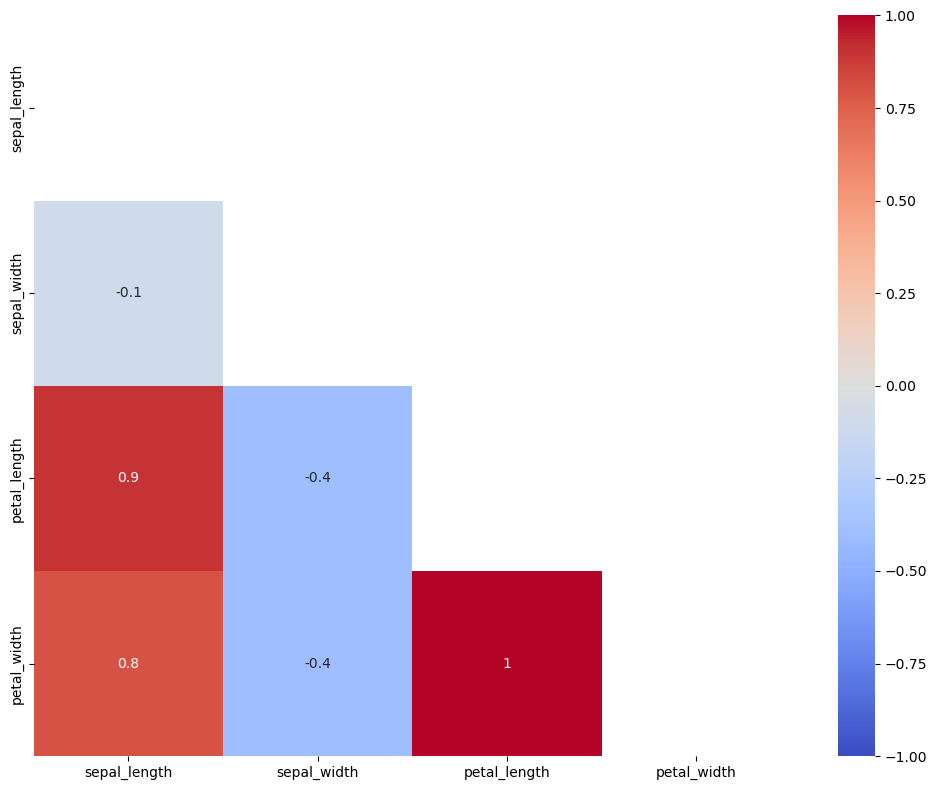

In [8]:
corr_data = iris.drop('species', axis = 1).corr()
mask = np.triu(np.ones_like(corr_data, dtype = bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data.round(1), cmap = 'coolwarm', mask = mask, vmin = -1, vmax = 1, annot = True)
plt.tight_layout()

There are some strong correlations among most of the variables. However, multicollinearity does not directly affect SVMs as severely as it does linear regressions or GLMs in general. Although it can have subtle effects on performance, it should not impact the predictions. Thus, I will not worry about correlations here, just performing these analysis as good practice.

### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = iris.drop('species', axis = 1)
y = iris['species']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Stardadisation of predictors

As good practice, I will also standardise the data. However, for this dataset, all variables are in the same units and magnitudes, so standardisation should not be a concern for this project.

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X.columns, index=X_test.index
)

In [14]:
X_train_scaled.head()

,sepal_length,sepal_width,petal_length,petal_width
13,-1.835510,-0.199387,-1.464449,-1.381358
102,1.493546,-0.199387,1.181007,1.123695
67,-0.052087,-0.905084,0.188961,-0.254084
34,-1.122141,0.035845,-1.243994,-1.256105
98,-0.884351,-1.375548,-0.417289,-0.128831


In [15]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
13,4.3,3.0,1.1,0.1
102,7.1,3.0,5.9,2.1
67,5.8,2.7,4.1,1.0
34,4.9,3.1,1.5,0.2
98,5.1,2.5,3.0,1.1


### Train the initial (default) model

In [16]:
from sklearn.svm import SVC

In [17]:
mod = SVC()

In [18]:
mod.fit(X_train_scaled, y_train)

SVC()

In [19]:
pred = mod.predict(X_test_scaled)

#### Model evaluation

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
print('=====================================')
print('Model evaluation for the initial SVC:')
print('=====================================')
print('\n')
print('Confusion matrix')
print('----------------')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print('Classification report')
print('---------------------')
print(classification_report(y_test,pred))

Model evaluation for the initial SVC:


Confusion matrix
----------------


[[13  0  0]
 [ 0 19  1]
 [ 0  0 12]]


Classification report
---------------------
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.95      0.97        20
   virginica       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



The Support Vector Classifier (SVC) achieved excellent performance on the Iris dataset, correctly classifying 98% of the test samples. The confusion matrix shows perfect predictions for setosa, with only a single misclassification between versicolor and virginica, which is expected given their natural overlap in feature space (we saw this in the plot above). The precision, recall, and F1-scores are all above 0.95 across classes, with macro and weighted averages of 0.98. These results indicate that the SVM model effectively captures the underlying structure of the data, demonstrating strong generalization and minimal bias toward any particular class.

### Gridsearch optimisation

Despite having a very strong model, I will integrate some gridsearch practice next, just to explore if the model can be further optimised for that one misclassification.

In [22]:
from sklearn.model_selection import GridSearchCV

Define a range of 'C' and 'gamma' parameters to perform the gridsearch.

In [23]:
param_grid = {'C': [0.1,1,10,100], 'gamma':[1,0.1,0.01, 0.001]}

In [24]:
grid = GridSearchCV(SVC(), param_grid, verbose=3)

In [25]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.857 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.714 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.810 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.762 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.714 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.714 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.714 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.762 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.714 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.762 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.333 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.01;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=3)

In [26]:
print(f' Best parameters: {grid.best_params_}')

 Best parameters: {'C': 1, 'gamma': 1}


In [27]:
grid_pred = grid.predict(X_test_scaled)

In [28]:
print('=============================================================')
print('Model evaluation for the optimal SVC (given our grid params):')
print('=============================================================')
print('\n')
print('Confusion matrix')
print('----------------')
print('\n')
print(confusion_matrix(y_test,grid_pred))
print('\n')
print('Classification report')
print('---------------------')
print(classification_report(y_test,grid_pred))

Model evaluation for the optimal SVC (given our grid params):


Confusion matrix
----------------


[[12  0  1]
 [ 0 19  1]
 [ 0  1 11]]


Classification report
---------------------
              precision    recall  f1-score   support

      setosa       1.00      0.92      0.96        13
  versicolor       0.95      0.95      0.95        20
   virginica       0.85      0.92      0.88        12

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



The grid-searched SVC performed slightly worse than the initial model, with accuracy dropping from 0.98 to 0.93 and small declines in precision and recall for setosa and virginica. While the first model classified nearly all samples correctly, the tuned version introduced a few extra misclassifications, likely because the new hyperparameters produced a smoother decision boundary that slightly underfit the small dataset. This doesn’t necessarily mean the model is inferior—grid search optimizes for cross-validation performance, not a single test split, and small datasets like Iris are sensitive to minor boundary shifts. In short, the tuned model generalizes more conservatively, but at a small cost to test accuracy.

# --- End of the project! ---